# Mål

Estimere total strømningshastighet gjennom en strupeventil. 
Total flow, av olje, gas og vann, er `QTOT`

Dataset er markert følgende:
- `CHK`: strupeventil opening - et nummer mellom [0,1]. 0 er lukker, 1 er helt åpen. 
- `PWH`: Trykk upstream fra strupeventilen (skalert)
- `PDC`: trykk downstream fra strupeventilen (skalert)
- `TWH`: temperatur upstream fra strupeventilen (skalert)
- `FGAS`: brøkdel av gass til total strømning,  mellom [0,1]
- `FOIL`: brøkdel av vann til total strømning, mellom [0,1]

Figur:

<img src="well_sensors.png">

### Ingen modell for total strømningshastighet, løsning: Dyp Læring

Med et dyp læring nettverk, skal vi lage en prediksjon:
$$QTOT = f_{\theta}(CHK, PWH, PDC, TWH, FGAS, FOIL)$$


# Framework - Keras

Open-source bibliotek for dyp læring i Python.
Bygget På tensorflow

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam


# Dataset

In [2]:
df = pd.read_csv('well_data.csv', index_col=0)
df

,CHK,PWH,PDC,TWH,FGAS,FOIL,QTOT
0,0.540,0.542755,0.211586,0.594760,0.138882,0.861118,32.358228
1,0.540,0.542755,0.211586,0.594760,0.142222,0.857774,32.940225
2,0.894,0.458000,0.222654,0.616555,0.144697,0.855303,48.633042
3,0.894,0.452311,0.222556,0.609029,0.144938,0.855056,48.065657
4,0.894,0.443485,0.221839,0.602488,0.144187,0.855807,47.096656
...,...,...,...,...,...,...,...
3094,0.534,0.462606,0.215561,0.592627,0.128039,0.826061,28.108285
3095,0.534,0.462854,0.216331,0.589506,0.127935,0.825378,28.119254
3096,0.534,0.463855,0.239411,0.594895,0.127857,0.824711,27.875849
3097,0.415,0.498174,0.234317,0.581882,0.129256,0.833875,18.412828


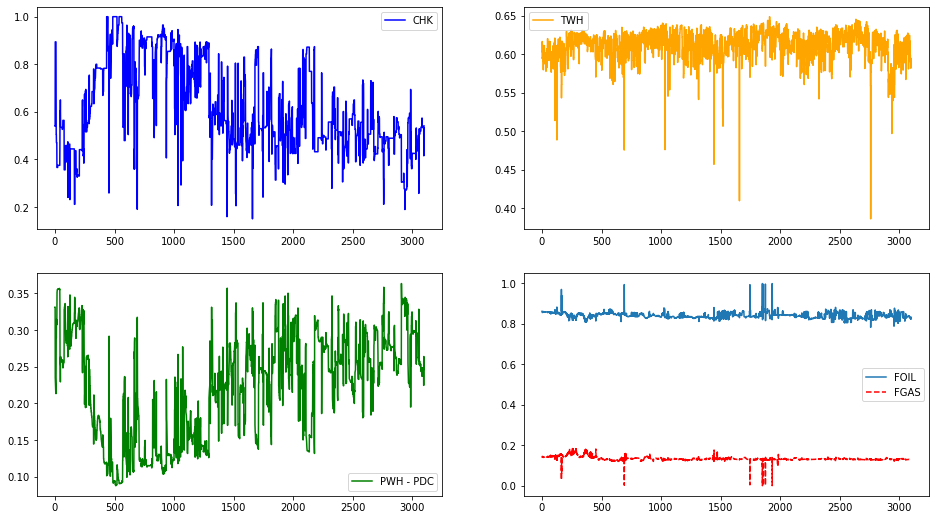

In [3]:
fig, ax = plt.subplots(2, 2, figsize=(16, 9))

# Choke valve opening
ax[0, 0].plot(df['CHK'], label='CHK', color="blue")
ax[0, 0].legend()

# Total floqw through choke valve
ax[0, 1].plot(df['TWH'], label='TWH', color='orange')
ax[0, 1].legend()

# Diff pressure over choke valve
ax[1, 0].plot(df['PWH'] - df['PDC'], label='PWH - PDC', color='green')
ax[1, 0].legend()

# Fractions
ax[1, 1].plot(df['FOIL'], label='FOIL')
ax[1, 1].plot(df['FGAS'], '--r', label='FGAS')
ax[1, 1].legend()

## Korrelasjon mellom data

In [4]:
df.corr()

,CHK,PWH,PDC,TWH,FGAS,FOIL,QTOT
CHK,1.000000,-0.963694,0.706279,0.285622,0.091705,-0.087384,0.935945
PWH,-0.963694,1.000000,-0.690669,-0.262040,-0.053365,0.097010,-0.889464
PDC,0.706279,-0.690669,1.000000,0.086445,-0.071751,-0.103538,0.647044
TWH,0.285622,-0.262040,0.086445,1.000000,0.070121,-0.096992,0.372099
FGAS,0.091705,-0.053365,-0.071751,0.070121,1.000000,-0.375864,0.189640
FOIL,-0.087384,0.097010,-0.103538,-0.096992,-0.375864,1.000000,-0.096468
QTOT,0.935945,-0.889464,0.647044,0.372099,0.189640,-0.096468,1.000000


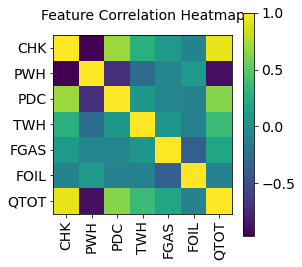

In [5]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)

## Split til training, validation og data set.

### Test data

In [6]:
test_set = df[2000:2500]

x_test = test_set.drop(columns='QTOT')
y_test = test_set[['QTOT']]

### Validation data

In [7]:
train_val_set = df.copy().drop(test_set.index) 
#train_val_set = df.iloc[0:500]

val_set = train_val_set.sample(frac=0.1, replace=False)

x_val = val_set.drop(columns='QTOT')
y_val = val_set[['QTOT']]

### Training data

In [8]:
train_set = train_val_set.copy().drop(val_set.index)

x_train = train_set.drop(columns='QTOT')
y_train = train_set[['QTOT']]

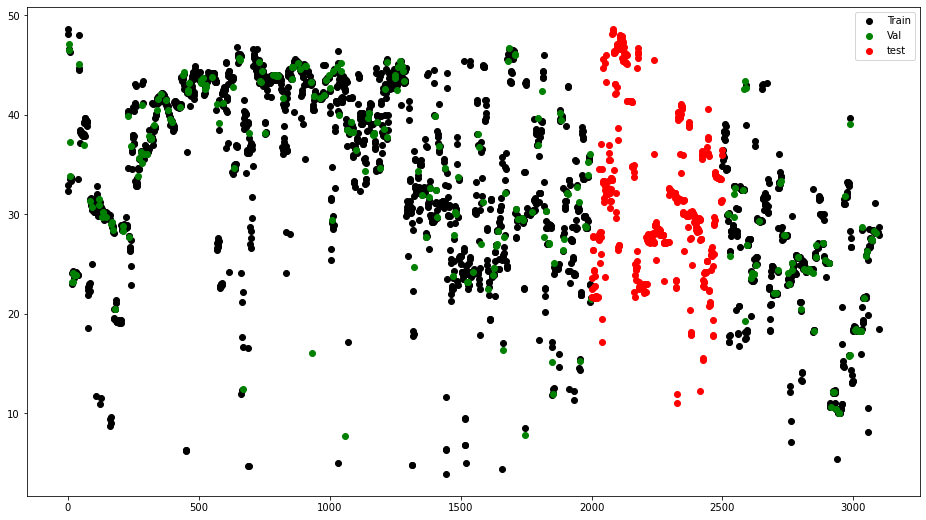

In [9]:
plt.figure(figsize=(16,9))
plt.scatter(y_train.index, y_train.values, color='black', label='Train')
plt.scatter(val_set.index, val_set['QTOT'], color='green', label='Val')
plt.scatter(y_test.index, y_test.values, color='red', label='test')
plt.legend()

# Enkel model

In [10]:
from keras import regularizers

input_layer_size = x_train.columns.size

model = keras.Sequential()
model.add(keras.layers.Dense(input_layer_size, activation='relu', input_shape=(input_layer_size,)))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(1))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 42        
_________________________________________________________________
dense_1 (Dense)              (None, 128)               896       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 9,259
Trainable params: 9,259
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [13]:
history = model.fit(x_train,y_train,validation_data=(x_val, y_val),epochs=200, batch_size=10,verbose=2)

Epoch 1/200
234/234 - 0s - loss: 417.0716 - val_loss: 82.3141
Epoch 2/200
234/234 - 0s - loss: 57.7891 - val_loss: 36.8073
Epoch 3/200
234/234 - 0s - loss: 20.0216 - val_loss: 11.4485
Epoch 4/200
234/234 - 0s - loss: 9.5892 - val_loss: 8.6479
Epoch 5/200
234/234 - 0s - loss: 8.0182 - val_loss: 7.5522
Epoch 6/200
234/234 - 0s - loss: 7.3905 - val_loss: 7.0732
Epoch 7/200
234/234 - 0s - loss: 6.9581 - val_loss: 6.8070
Epoch 8/200
234/234 - 0s - loss: 6.7130 - val_loss: 6.6243
Epoch 9/200
234/234 - 0s - loss: 6.6881 - val_loss: 6.4071
Epoch 10/200
234/234 - 0s - loss: 6.5035 - val_loss: 6.3268
Epoch 11/200
234/234 - 0s - loss: 6.4391 - val_loss: 6.4203
Epoch 12/200
234/234 - 0s - loss: 6.3859 - val_loss: 6.2772
Epoch 13/200
234/234 - 0s - loss: 6.4025 - val_loss: 6.7371
Epoch 14/200
234/234 - 0s - loss: 6.3066 - val_loss: 6.0217
Epoch 15/200
234/234 - 0s - loss: 6.1587 - val_loss: 6.7317
Epoch 16/200
234/234 - 0s - loss: 6.1602 - val_loss: 5.9974
Epoch 17/200
234/234 - 0s - loss: 6.0693 -

Epoch 137/200
234/234 - 0s - loss: 3.9264 - val_loss: 3.9983
Epoch 138/200
234/234 - 0s - loss: 3.8639 - val_loss: 4.1938
Epoch 139/200
234/234 - 0s - loss: 3.9513 - val_loss: 4.0181
Epoch 140/200
234/234 - 0s - loss: 4.0698 - val_loss: 4.6784
Epoch 141/200
234/234 - 0s - loss: 4.0289 - val_loss: 3.9729
Epoch 142/200
234/234 - 0s - loss: 4.0141 - val_loss: 4.0288
Epoch 143/200
234/234 - 0s - loss: 3.8807 - val_loss: 4.1553
Epoch 144/200
234/234 - 0s - loss: 3.8239 - val_loss: 4.3930
Epoch 145/200
234/234 - 0s - loss: 3.7973 - val_loss: 4.0059
Epoch 146/200
234/234 - 0s - loss: 3.8223 - val_loss: 4.1287
Epoch 147/200
234/234 - 0s - loss: 3.9834 - val_loss: 4.9196
Epoch 148/200
234/234 - 0s - loss: 3.8764 - val_loss: 4.2503
Epoch 149/200
234/234 - 0s - loss: 3.9378 - val_loss: 3.9861
Epoch 150/200
234/234 - 0s - loss: 3.8134 - val_loss: 4.0657
Epoch 151/200
234/234 - 0s - loss: 3.8342 - val_loss: 4.9947
Epoch 152/200
234/234 - 0s - loss: 3.8899 - val_loss: 3.9707
Epoch 153/200
234/234 - 

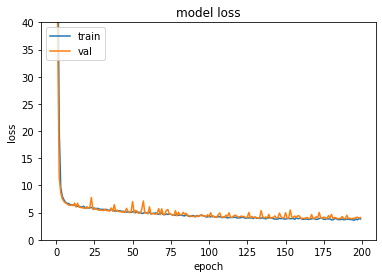

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
axes = plt.gca()
axes.set_ylim([0,40])
plt.show()

In [15]:
keras_predictions = model.predict(x_test, verbose=2)

16/16 - 0s


In [16]:

print("Error on test data simple model")
mse_test_simple = np.mean(np.power(keras_predictions - y_test.values, 2))
print("MSE: ", mse_test_simple) #2.6873526

mae_test_simple = np.mean(np.abs(keras_predictions-y_test.values))
print("MAE: ", mae_test_simple) # 1.12

mape_test_simple = 100*np.mean(np.abs(np.divide(keras_predictions - y_test.values, y_test.values)))
print("MAPE: ", mape_test_simple, "%") # 3.574



Error on test data simple model
MSE:  2.922150059314377
MAE:  1.3057625648771782
MAPE:  3.991042465326254 %


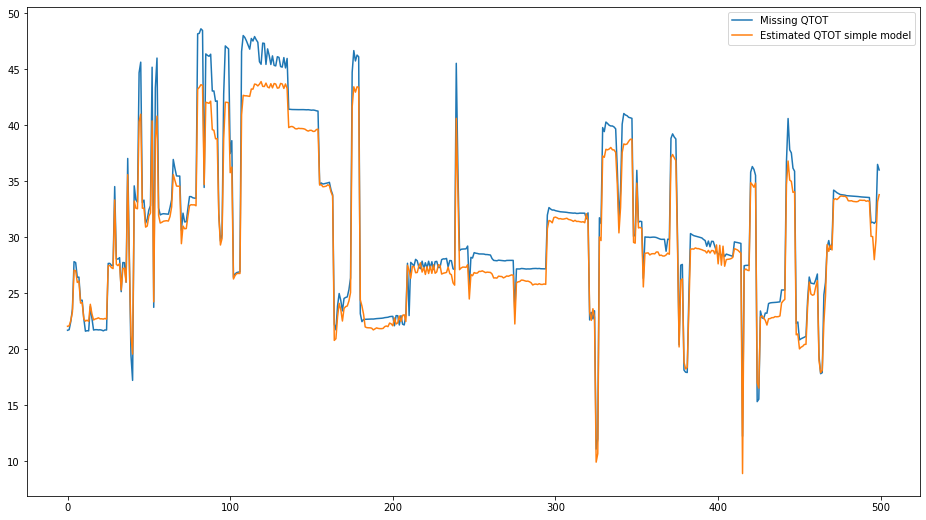

In [17]:
plt.figure(figsize=(16,9))
plt.plot(y_test.values, label='Missing QTOT')
plt.plot(keras_predictions, label='Estimated QTOT simple model')
plt.legend()

# Forbedret model

### Legge til dropout lag

In [18]:
from keras.layers import Dropout

input_layer_size = x_train.columns.size

improved_model = keras.Sequential()
improved_model.add(keras.layers.Dense(input_layer_size, activation='relu', input_shape=(input_layer_size,)))
model.add(keras.layers.Dropout(0.4))
improved_model.add(keras.layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.Dropout(0.4))
improved_model.add(keras.layers.Dense(1))

In [19]:
improved_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 56        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 107
Trainable params: 107
Non-trainable params: 0
_________________________________________________________________


In [20]:
improved_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

### Early stopping

In [21]:
from keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestClassifier

callback = EarlyStopping(monitor='val_loss', patience=6)


improved_history = improved_model.fit(x_train,y_train,validation_data=(x_val, y_val),epochs=200, batch_size=10, callbacks=[callback],verbose=2)

Epoch 1/200
234/234 - 0s - loss: 1125.3257 - val_loss: 1020.8192
Epoch 2/200
234/234 - 0s - loss: 799.0695 - val_loss: 523.6060
Epoch 3/200
234/234 - 0s - loss: 288.3712 - val_loss: 120.7480
Epoch 4/200
234/234 - 0s - loss: 76.7047 - val_loss: 61.5169
Epoch 5/200
234/234 - 0s - loss: 55.5021 - val_loss: 54.8611
Epoch 6/200
234/234 - 0s - loss: 49.6317 - val_loss: 49.0031
Epoch 7/200
234/234 - 0s - loss: 43.8963 - val_loss: 43.1185
Epoch 8/200
234/234 - 0s - loss: 38.1886 - val_loss: 37.2964
Epoch 9/200
234/234 - 0s - loss: 32.6775 - val_loss: 31.7675
Epoch 10/200
234/234 - 0s - loss: 27.5583 - val_loss: 26.7669
Epoch 11/200
234/234 - 0s - loss: 22.9992 - val_loss: 22.4131
Epoch 12/200
234/234 - 0s - loss: 19.2271 - val_loss: 18.7975
Epoch 13/200
234/234 - 0s - loss: 16.0838 - val_loss: 15.9571
Epoch 14/200
234/234 - 0s - loss: 13.7981 - val_loss: 13.8824
Epoch 15/200
234/234 - 0s - loss: 12.0997 - val_loss: 12.9300
Epoch 16/200
234/234 - 0s - loss: 11.0571 - val_loss: 11.3388
Epoch 17/

Epoch 137/200
234/234 - 0s - loss: 5.6804 - val_loss: 5.8994
Epoch 138/200
234/234 - 0s - loss: 5.6658 - val_loss: 5.8965
Epoch 139/200
234/234 - 0s - loss: 5.7136 - val_loss: 5.8884
Epoch 140/200
234/234 - 0s - loss: 5.6955 - val_loss: 6.1205
Epoch 141/200
234/234 - 0s - loss: 5.6471 - val_loss: 5.9045
Epoch 142/200
234/234 - 0s - loss: 5.6447 - val_loss: 6.1588
Epoch 143/200
234/234 - 0s - loss: 5.6768 - val_loss: 5.8965
Epoch 144/200
234/234 - 0s - loss: 5.6422 - val_loss: 5.9169
Epoch 145/200
234/234 - 0s - loss: 5.6459 - val_loss: 5.8588
Epoch 146/200
234/234 - 0s - loss: 5.6177 - val_loss: 5.9529
Epoch 147/200
234/234 - 0s - loss: 5.6193 - val_loss: 5.9048
Epoch 148/200
234/234 - 0s - loss: 5.5665 - val_loss: 5.8869
Epoch 149/200
234/234 - 0s - loss: 5.6177 - val_loss: 5.8264
Epoch 150/200
234/234 - 0s - loss: 5.5850 - val_loss: 5.8322
Epoch 151/200
234/234 - 0s - loss: 5.5847 - val_loss: 5.8555
Epoch 152/200
234/234 - 0s - loss: 5.6486 - val_loss: 5.9573
Epoch 153/200
234/234 - 

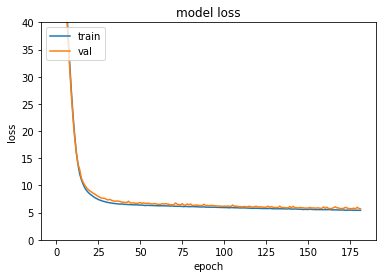

In [22]:
plt.plot(improved_history.history['loss'])
plt.plot(improved_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
axes = plt.gca()
axes.set_ylim([0,40])
plt.show()

In [23]:
improved_keras_predictions = improved_model.predict(x_test, verbose=2)

16/16 - 0s


In [24]:

print("Error on test data improved model")
mse_test_improved = np.mean(np.power(improved_keras_predictions - y_test.values, 2))
print("MSE: ", mse_test_improved) #2.6873526

mae_test_improved = np.mean(np.abs(improved_keras_predictions-y_test.values))
print("MAE: ", mae_test_improved) # 1.12

mape_test_improved = 100*np.mean(np.abs(np.divide(improved_keras_predictions - y_test.values, y_test.values)))
print("MAPE: ", mape_test_improved, "%") # 3.574



Error on test data improved model
MSE:  2.8832007565941247
MAE:  1.1427502140602588
MAPE:  3.389982497736648 %


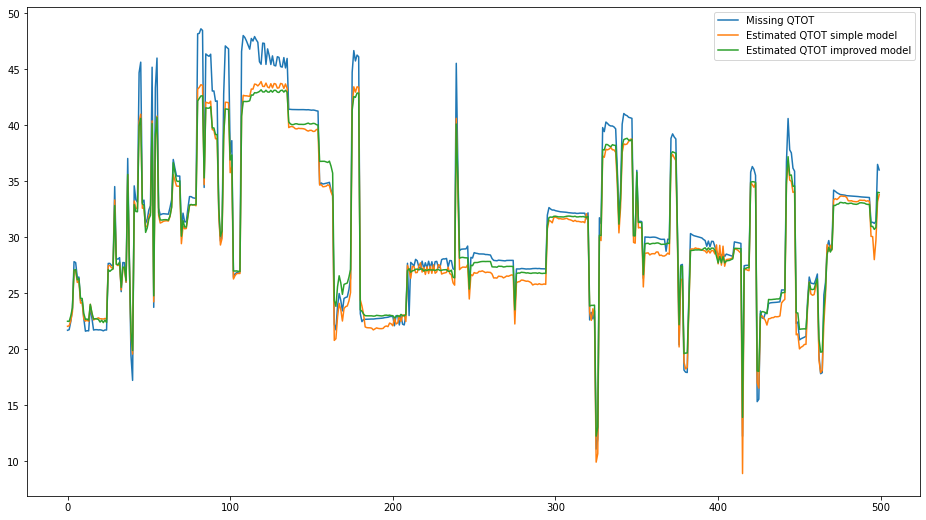

In [25]:
plt.figure(figsize=(16,9))
plt.plot(y_test.values, label='Missing QTOT')
plt.plot(keras_predictions, label='Estimated QTOT simple model')
plt.plot(improved_keras_predictions, label='Estimated QTOT improved model')
plt.legend()

In [26]:
import numpy as np
from tabulate import tabulate

m = np.array([["MSE", mse_test_simple, mse_test_improved],["MAE", mae_test_simple, mae_test_improved ],["MAPE", mape_test_simple, mape_test_improved]]);

headers = ["old", "new"]

table = tabulate(m, headers, tablefmt="fancy_grid")

print(table)


╒══════╤═════════╤═════════╕
│      │     old │     new │
╞══════╪═════════╪═════════╡
│ MSE  │ 2.92215 │ 2.8832  │
├──────┼─────────┼─────────┤
│ MAE  │ 1.30576 │ 1.14275 │
├──────┼─────────┼─────────┤
│ MAPE │ 3.99104 │ 3.38998 │
╘══════╧═════════╧═════════╛
